In [1]:
import numpy as np
import torch
import random
import math
from collections import namedtuple
import os
import time

from scipy.spatial import distance_matrix
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix
from scipy.sparse.csgraph import connected_components

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from scipy.signal import medfilt

""" Note: the code is not optimized for GPU
"""
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cuda')

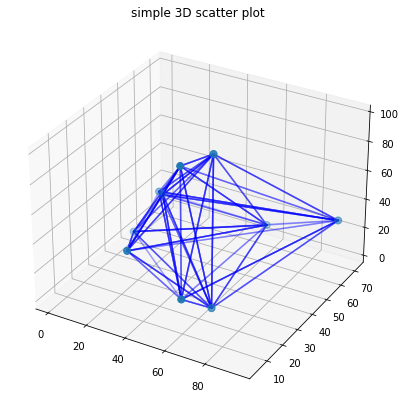

In [2]:
def get_graph_mat(n=10, size=1, n_coords=3):
    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
    """
    coords = size * np.random.uniform(size=(n,n_coords))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat

def plot_graph(coords, mat):
    """ Utility function to plot the fully connected graph
    """
    n = len(coords)
    
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")

    # Creating plot
    ax.scatter3D(coords[:, 0], coords[:, 1], coords[:, 2], s=[50 for _ in range(n)])
    plt.title("simple 3D scatter plot")
    for i in range(n):
        for j in range(n):
            for k in range(n):
                if i < j < k:
                    plt.plot(
                        [coords[i,0], coords[j,0], coords[k,0]], 
                        [coords[i,1], coords[j,1], coords[k,1]], 
                        [coords[i,2], coords[j,2], coords[k,2]], 
                        'b', 
                        alpha=0.2
                    )
                
    # show plot
    plt.show()

coords, W_np = get_graph_mat(n=10, size=100, n_coords=3)
plot_graph(coords, W_np)                

In [3]:
!pip install python-tsp --quiet

In [4]:
# coords.shape
W_np.shape

(10, 10)

In [5]:
from python_tsp.exact import solve_tsp_dynamic_programming

permutation, distance = solve_tsp_dynamic_programming(W_np)
print(distance, permutation)

422.76912409358073 [0, 6, 9, 5, 3, 2, 7, 4, 8, 1]


In [6]:
""" A function to plot solutions
"""
def plot_solution(coords, mat, solution):
    # Creating figure
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    
    ax.scatter3D(coords[:,0], coords[:,1], coords[:,2])
    n = len(coords)
    
    for idx in range(n-1):
        i, next_i = solution[idx], solution[idx+1]
        plt.plot(
            [coords[i, 0], coords[next_i, 0]], 
            [coords[i, 1], coords[next_i, 1]], 
            [coords[i, 2], coords[next_i, 2]], 
            'k', 
            lw=2, 
            alpha=0.8
        )
    
    i, next_i = solution[-1], solution[0]
    plt.plot(
        [coords[i, 0], coords[next_i, 0]], 
        [coords[i, 1], coords[next_i, 1]],
        [coords[i, 2], coords[next_i, 2]],
        'k', 
        lw=2, 
        alpha=0.8
    )
    plt.plot(coords[solution[0], 0], coords[solution[0], 1], coords[solution[0], 2], 'x', markersize=10)

def total_distance(solution, W):
    if len(solution) < 2:
        return 0  # there is no travel
    
    total_dist = 0
    for i in range(len(solution) - 1):
        total_dist += W[solution[i], solution[i+1]].item()
        
    # if this solution is "complete", go back to initial point
    if len(solution) == W.shape[0]:
        total_dist += W[solution[-1], solution[0]].item()

    return total_dist

## solving with dynamic programming

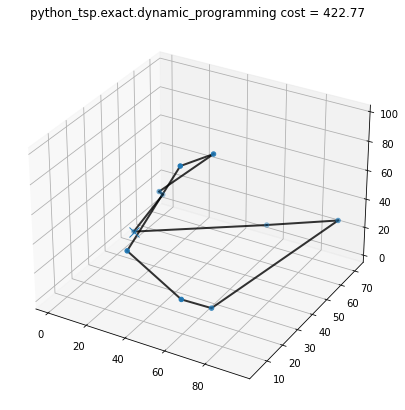

In [7]:
plot_solution(coords, W_np, permutation)
_ = plt.title(f'python_tsp.exact.dynamic_programming cost = {total_distance(permutation, W_np):0.2f}')
plt.show()

# approximate solvers

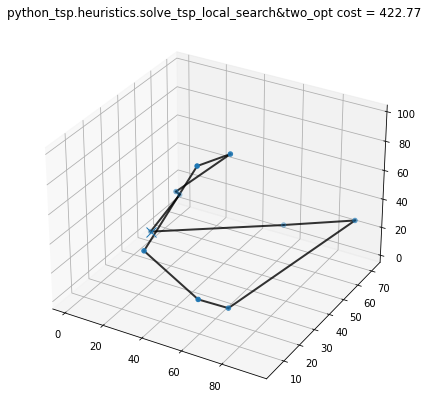

In [8]:
from python_tsp.heuristics.local_search import solve_tsp_local_search

"""
python benchmark all of the heurstics for swapping for different sizes
    "ps1": ps1_gen,
    "ps2": ps2_gen,
    "ps3": ps3_gen,
    "ps4": ps4_gen,
    "ps5": ps5_gen,
    "ps6": ps6_gen,
    "two_opt": two_opt_gen,
"""

permutation, distance = solve_tsp_local_search(W_np, perturbation_scheme= "two_opt")
plot_solution(coords, W_np, permutation)
_ = plt.title(f'python_tsp.heuristics.solve_tsp_local_search&two_opt cost = {total_distance(permutation, W_np):0.2f}')
plt.show()

# Solving with RL & Graph Networks

In [9]:
State = namedtuple('State', ('W', 'coords', 'partial_solution'))
  
def state2tens(state):
    """ Creates a Pytorch tensor representing the history of visited nodes, from a (single) state tuple.
        
        Returns a (Nx5) tensor, where for each node we store whether this node is in the sequence,
        whether it is first or last, and its (x,y) coordinates.
    """
    solution = set(state.partial_solution)
    sol_last_node = state.partial_solution[-1] if len(state.partial_solution) > 0 else -1
    sol_first_node = state.partial_solution[0] if len(state.partial_solution) > 0 else -1
    coords = state.coords
    nr_nodes = coords.shape[0]

    xv = [[(1 if i in solution else 0),
           (1 if i == sol_first_node else 0),
           (1 if i == sol_last_node else 0),
           coords[i,0],
           coords[i,1],
           coords[i,2],
          ] for i in range(nr_nodes)]
    
    return torch.tensor(xv, dtype=torch.float32, requires_grad=False, device=device)

# Q function
Q(s, a) ~ scalar that represents the value of taking an action $a$ at a state $s$

In [10]:
class QNet(nn.Module):
    """ The neural net that will parameterize the function Q(s, a)
    
        The input is the state (containing the graph and visited nodes),
        and the output is a vector of size N containing Q(s, a) for each of the N actions a.
    """    
    
    def __init__(self, emb_dim, T=4):
        """ emb_dim: embedding dimension p
            T: number of iterations for the graph embedding
        """
        super(QNet, self).__init__()
        self.emb_dim = emb_dim
        self.T = T
        
        # We use 5 dimensions for representing the nodes' states:
        # * A binary variable indicating whether the node has been visited
        # * A binary variable indicating whether the node is the first of the visited sequence
        # * A binary variable indicating whether the node is the last of the visited sequence
        # * The (x, y, z) coordinates of the node.
        self.node_dim = 6
        
        # We can have an extra layer after theta_1 (for the sake of example to make the network deeper)
        nr_extra_layers_1 = 4
        
        # Build the learnable affine maps:
        self.theta1 = nn.Linear(self.node_dim, self.emb_dim, True)
        self.theta2 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta3 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta4 = nn.Linear(1, self.emb_dim, True)
        self.theta5 = nn.Linear(2*self.emb_dim, 1, True)
        self.theta6 = nn.Linear(self.emb_dim, self.emb_dim, True)
        self.theta7 = nn.Linear(self.emb_dim, self.emb_dim, True)
        
        self.theta1_extras = nn.ModuleList([nn.Linear(self.emb_dim, self.emb_dim, True) for _ in range(nr_extra_layers_1)])
        
        self.relu = nn.ReLU()
        
    def forward(self, xv, Ws):
        # xv: The node features (batch_size, num_nodes, node_dim)
        # Ws: The graphs (batch_size, num_nodes, num_nodes)
        
        num_nodes = xv.shape[1]
        batch_size = xv.shape[0]
        
        # pre-compute 1-0 connection matrices masks (batch_size, num_nodes, num_nodes)
        conn_matrices = torch.where(Ws > 0, torch.ones_like(Ws), torch.zeros_like(Ws)).to(device)
        
        # Graph embedding
        # Note: we first compute s1 and s3 once, as they are not dependent on mu
        mu = torch.zeros(batch_size, num_nodes, self.emb_dim, device=device)
        s1 = self.theta1(xv)  # (batch_size, num_nodes, emb_dim)
        for layer in self.theta1_extras:
            out = self.relu(s1)
            s1 = layer(out)  # we apply the extra layer
        
        s3_1 = self.relu(self.theta4(Ws.unsqueeze(-1)))  # (batch_size, nr_nodes, nr_nodes, emb_dim) - each "weigth" is a p-dim vector        
        s3_2 = torch.sum(s3_1, dim=1)  # (batch_size, nr_nodes, emb_dim) - the embedding for each node
        s3 = self.theta3(s3_2)  # (batch_size, nr_nodes, emb_dim)
        
        for t in range(self.T):
            s2 = self.theta2(conn_matrices.matmul(mu))    
            mu = self.relu(s1 + s2 + s3)
            
        """ prediction
        """
        # we repeat the global state (summed over nodes) for each node, 
        # in order to concatenate it to local states later
        global_state = self.theta6(torch.sum(mu, dim=1, keepdim=True).repeat(1, num_nodes, 1))
        
        local_action = self.theta7(mu)  # (batch_dim, nr_nodes, emb_dim)
            
        out = self.relu(torch.cat([global_state, local_action], dim=2))
        return self.relu(self.theta5(out).squeeze(dim=2))

model output: tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0', grad_fn=<SelectBackward>)


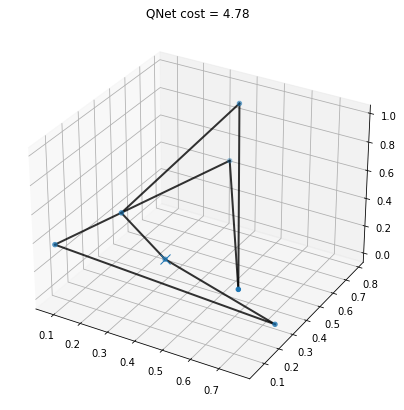

In [11]:
""" See what the model returns
"""
model = QNet(8, T=4).to(device)

# sample a new random graph
coords, W_np = get_graph_mat(n=7, n_coords=3)
W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)

# current state (tuple and tensor)
current_state = State(partial_solution=[], W=W, coords=coords)
current_state_tsr = state2tens(current_state)


y = model(current_state_tsr.unsqueeze(0), W.unsqueeze(0))[0]
print(f'model output: {y}')
print(y)


plot_solution(coords, W_np, y.argsort(descending=True))
_ = plt.title(f'QNet cost = {total_distance(y.argsort(descending=True), W_np):0.2f}')
plt.show()

In [12]:
class QFunction():
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.MSELoss()
    
    def predict(self, state_tsr, W):
        # batch of 1 - only called at inference time
        with torch.no_grad():
            estimated_rewards = self.model(state_tsr.unsqueeze(0), W.unsqueeze(0))
        return estimated_rewards[0]
                
    def get_best_action(self, state_tsr, state):
        """ Computes the best (greedy) action to take from a given state
            Returns a tuple containing the ID of the next node and the corresponding estimated reward
        """
        W = state.W
        estimated_rewards = self.predict(state_tsr, W)  # size (nr_nodes,)
        sorted_reward_idx = estimated_rewards.argsort(descending=True)
        
        solution = state.partial_solution
        
        already_in = set(solution)
        for idx in sorted_reward_idx.tolist():
            if (len(solution) == 0 or W[solution[-1], idx] > 0) and idx not in already_in:
                return idx, estimated_rewards[idx].item()
        
    def batch_update(self, states_tsrs, Ws, actions, targets):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        self.optimizer.zero_grad()
        
        # the rewards estimated by Q for the given actions
        estimated_rewards = self.model(xv, Ws_tsr)[range(len(actions)), actions]
        
        loss = self.loss_fn(estimated_rewards, torch.tensor(targets, device=device))
        loss_val = loss.item()
        
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

In [13]:
import torch
import torch.nn as nn
a = torch.randn(2, 3, requires_grad=True)
input = torch.softmax( a.clone(), dim=1)
target = input.detach().clone() # torch.randn(2, 3, requires_grad=True)

kl_loss = nn.KLDivLoss(reduction = 'batchmean')
output = kl_loss( torch.log( input), target)
output.backward(retain_graph=True)

print('input: ', input)
print('target: ', target)
print('output: ', output)

print('\n\n')


target = torch.softmax( torch.randn(2, 3, requires_grad=True), dim=1)

kl_loss = nn.KLDivLoss(reduction = 'batchmean')
output = kl_loss(torch.log( input), target)
output.backward()

print('input: ', input)
print('target: ', target)
print('output: ', output)

input:  tensor([[0.2765, 0.2926, 0.4309],
        [0.3122, 0.0227, 0.6651]], grad_fn=<SoftmaxBackward>)
target:  tensor([[0.2765, 0.2926, 0.4309],
        [0.3122, 0.0227, 0.6651]])
output:  tensor(0., grad_fn=<DivBackward0>)



input:  tensor([[0.2765, 0.2926, 0.4309],
        [0.3122, 0.0227, 0.6651]], grad_fn=<SoftmaxBackward>)
target:  tensor([[0.1320, 0.3125, 0.5555],
        [0.0822, 0.4356, 0.4822]], grad_fn=<SoftmaxBackward>)
output:  tensor(0.5430, grad_fn=<DivBackward0>)


In [14]:
# Note: we store state tensors in experience to compute these tensors only once later on
Experience = namedtuple('Experience', ('state', 'state_tsr', 'action', 'reward', 'next_state', 'next_state_tsr'))

class Memory(object):
    # deque?
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0
        self.nr_inserts = 0
        
    def remember(self, experience):
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = experience
        self.position = (self.position + 1) % self.capacity
        self.nr_inserts += 1
        
    def sample_batch(self, batch_size):
        return random.sample(self.memory, batch_size)
    
    def __len__(self):
        return min(self.nr_inserts, self.capacity)


In [15]:
def is_state_final(state):
    return len(set(state.partial_solution)) == state.W.shape[0]

def get_next_neighbor_random(state):
    solution, W = state.partial_solution, state.W
    
    if len(solution) == 0:
        return random.choice(range(W.shape[0]))
    already_in = set(solution)
    candidates = list(filter(lambda n: n.item() not in already_in, W[solution[-1]].nonzero()))
    if len(candidates) == 0:
        return None
    return random.choice(candidates).item()

In [16]:
SEED = 1  # A seed for the random number generator

# Graph
NR_NODES = 10  # Number of nodes N
EMBEDDING_DIMENSIONS = 8  # Embedding dimension D
EMBEDDING_ITERATIONS_T = 4  # Number of embedding iterations T

# Learning
NR_EPISODES = 501
MEMORY_CAPACITY = 10000
N_STEP_QL = 2  # Number of steps (n) in n-step Q-learning to wait before computing target reward estimate
BATCH_SIZE = 64

GAMMA = 0.9
INIT_LR = 5e-2
LR_DECAY_RATE = 1. - 2e-5  # learning rate decay

MIN_EPSILON = 0.1
EPSILON_DECAY_RATE = 9e-5  # epsilon decay

FOLDER_NAME = f'./{NR_NODES}_{EMBEDDING_DIMENSIONS}_{SEED}_{BATCH_SIZE}_{EPSILON_DECAY_RATE}'  # where to checkpoint the best models

In [17]:
class ClassificationFunction(QFunction):
    def __init__(self, model, optimizer, lr_scheduler):
        self.model = model  # The actual QNet
        self.optimizer = optimizer
        self.lr_scheduler = lr_scheduler
        self.loss_fn = nn.KLDivLoss(reduction = 'batchmean')
        
    def batch_update(self, states_tsrs, Ws, target_prio_prob):
        """ Take a gradient step using the loss computed on a batch of (states, Ws, actions, targets)
        
            states_tsrs: list of (single) state tensors
            Ws: list of W tensors
            actions: list of actions taken
            targets: list of targets (resulting estimated rewards after taking the actions)
        """        
        Ws_tsr = torch.stack(Ws).to(device)
        xv = torch.stack(states_tsrs).to(device)
        
        
        # the rewards estimated by Q for the given actions available
        city_prio_prob = self.model(xv, Ws_tsr)
        print(range(len(actions)), actions)
        
        loss = self.loss_fn( torch.log(city_prio_prob), target_prio_prob)
        loss_val = loss.item()
        
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()        
        self.lr_scheduler.step()
        
        return loss_val

def init_model(fname=None):
    """ Create a new model. If fname is defined, load the model from the specified file.
    """
    Q_net = QNet(EMBEDDING_DIMENSIONS, T=EMBEDDING_ITERATIONS_T).to(device)
    optimizer = optim.Adam(Q_net.parameters(), lr=INIT_LR)
    lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=LR_DECAY_RATE)
    
    if fname is not None:
        checkpoint = torch.load(fname)
        Q_net.load_state_dict(checkpoint['model'])
        optimizer.load_state_dict(checkpoint['optimizer'])
        lr_scheduler.load_state_dict(checkpoint['lr_scheduler'])
    
    Q_func = ClassificationFunction(Q_net, optimizer, lr_scheduler)
    return Q_func, Q_net, optimizer, lr_scheduler

def checkpoint_model(model, optimizer, lr_scheduler, loss, 
                     episode, avg_length):
    if not os.path.exists(FOLDER_NAME):
        os.makedirs(FOLDER_NAME)
    
    fname = os.path.join(FOLDER_NAME, 'ep_{}'.format(episode))
    fname += '_length_{}'.format(avg_length)
    fname += '.tar'
    
    torch.save({
        'episode': episode,
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'lr_scheduler': lr_scheduler.state_dict(),
        'loss': loss,
        'avg_length': avg_length
    }, fname)

In [18]:
class TSPDataset(torch.utils.data.Dataset):
    def __init__(self, num_samples=10, num_cities=NR_NODES, p=0.5):
        self.num_samples = num_samples
        self.num_cities = num_cities
        self.p = p
        
        self._samples = self._make_samples(self.num_samples, num_cities=num_cities, p=self.p)
        
    def _make_samples(self, num_samples:int, num_cities:int, p:float) -> list:
        return [self._make_sample(num_cities, p) for _ in range(num_samples)]
    
    def _make_sample(self, num_cities:int, p: float):
        # make random cities
        points, cost_matrix = get_graph_mat(n=num_cities, n_coords=3)

        # make ground truth
        permutation, distance = solve_tsp_dynamic_programming(cost_matrix)

        ## TODO: if NR_NODES > 10, then use heuristic
        #### If using heuristic, check to see if model found a better solution, if yes, update dataset with better solution

        # convert groundtruth to probability distribution
        city_selection = [float(((1-p)**permutation.index(city)) * p) for city in range(len(permutation))]
        target_prio_prob = torch.softmax(torch.tensor(city_selection, device=device).unsqueeze(0), dim=1)

        return points, cost_matrix, target_prio_prob

    def __len__(self):
        return len(self._samples)

    def __getitem__(self, idx):
        return self._samples[idx]
    
TSPDataset(num_samples=2, num_cities=NR_NODES, p=0.5)[0][-1]

tensor([[0.1473, 0.1012, 0.0895, 0.1147, 0.0894, 0.0897, 0.0922, 0.0951, 0.0908,
         0.0900]], device='cuda:0')

In [32]:
# seed everything for reproducible results first:
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Create module, optimizer, LR scheduler, and Q-function
Q_func, Q_net, optimizer, lr_scheduler = init_model()

# Create memory
memory = Memory(MEMORY_CAPACITY)

# Storing metrics about training:
found_solutions = dict()  # episode --> (coords, W, solution)
losses = []
path_lengths = []

# keep track of median path length for model checkpointing
current_min_med_length = float('inf')

train_dataloader = torch.utils.data.DataLoader(
    TSPDataset(num_samples=1024, num_cities=NR_NODES, p=0.5), 
    batch_size=64, 
    num_workers=0, 
    shuffle=True
)

loss_fn = nn.KLDivLoss(reduction = 'batchmean')

In [36]:
for epoch in range(30):
    for batch in train_dataloader:
        coords, cost_matricies, target_prio_probs = batch

        # current state (tuple and tensor)
        current_state_tsrs = torch.stack([state2tens(State(partial_solution=[], W=cost_matrix, coords=points)) for points, cost_matrix in zip(coords, cost_matricies)])
        
        # shouldn't have to do this here??? I dunno
        current_state_tsrs = current_state_tsrs.to(device)
        cost_matricies = cost_matricies.float().to(device)
        
        city_prio_prob = Q_net(current_state_tsrs, cost_matricies)
        
        loss = loss_fn( torch.log(torch.softmax(city_prio_prob, dim=1)), target_prio_probs.squeeze().to(device))
        losses.append(loss.item())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()        
        lr_scheduler.step()

Text(0.5, 0, 'training iteration')

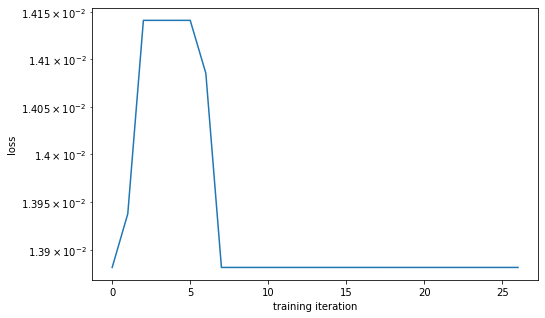

In [37]:
def _moving_avg(x, N=10):
    return np.convolve(np.array(x), np.ones((N,))/N, mode='valid')

plt.figure(figsize=(8,5))
plt.semilogy(_moving_avg(losses, 5))
plt.ylabel('loss')
plt.xlabel('training iteration')

# plt.figure(figsize=(8,5))
# plt.plot(_moving_avg(path_lengths, 100))
# plt.ylabel('average length')
# plt.xlabel('episode')

shortest avg length found: 6.374086461961269


<ipython-input-25-493f8736dc3e>:34: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


<Figure size 432x288 with 0 Axes>

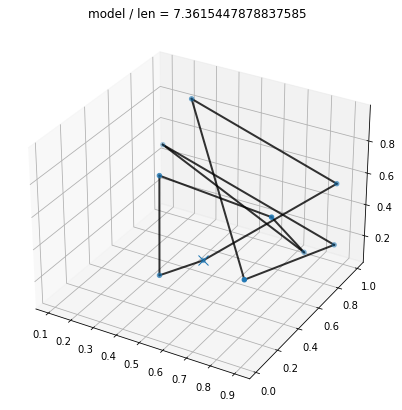

<Figure size 432x288 with 0 Axes>

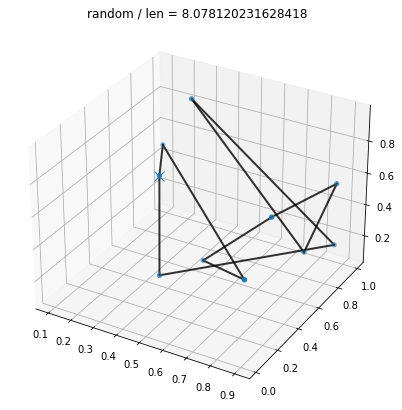

<Figure size 432x288 with 0 Axes>

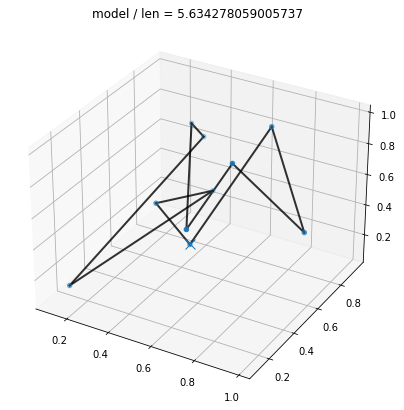

<Figure size 432x288 with 0 Axes>

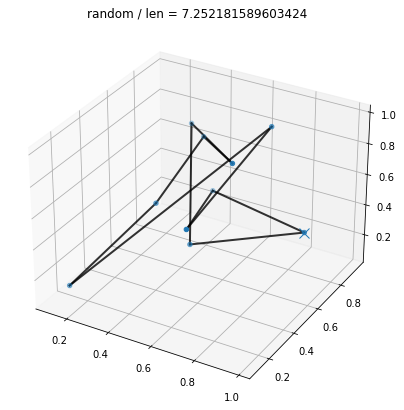

<Figure size 432x288 with 0 Axes>

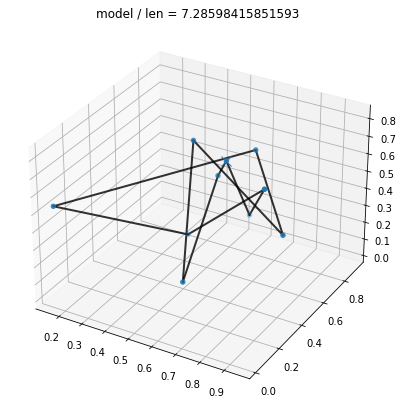

<Figure size 432x288 with 0 Axes>

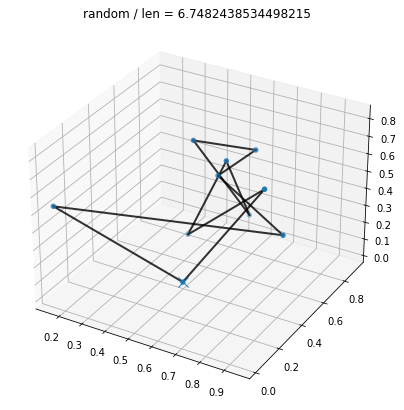

<Figure size 432x288 with 0 Axes>

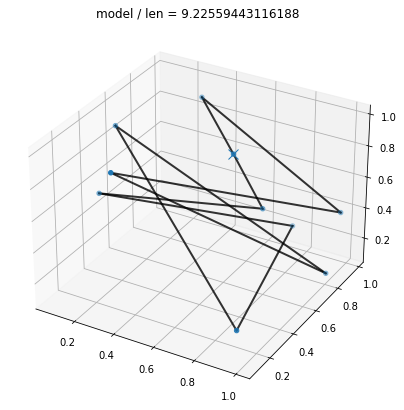

<Figure size 432x288 with 0 Axes>

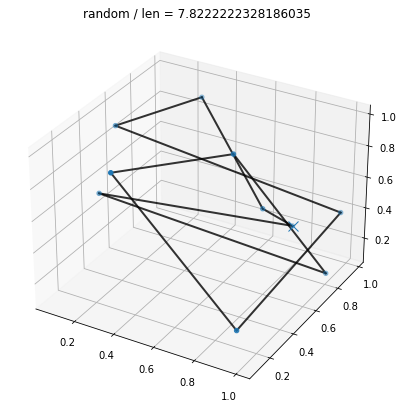

<Figure size 432x288 with 0 Axes>

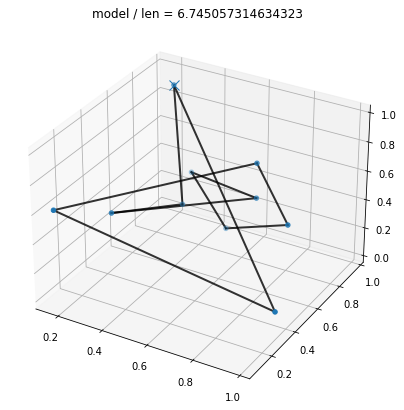

<Figure size 432x288 with 0 Axes>

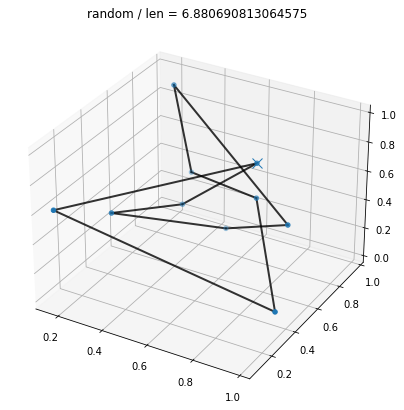

<Figure size 432x288 with 0 Axes>

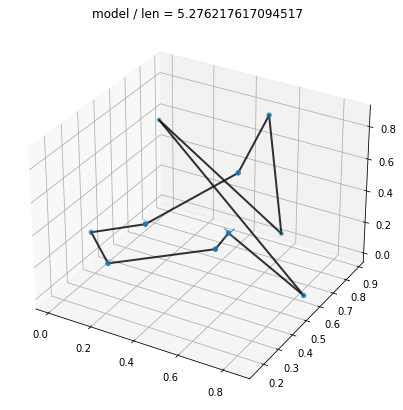

<Figure size 432x288 with 0 Axes>

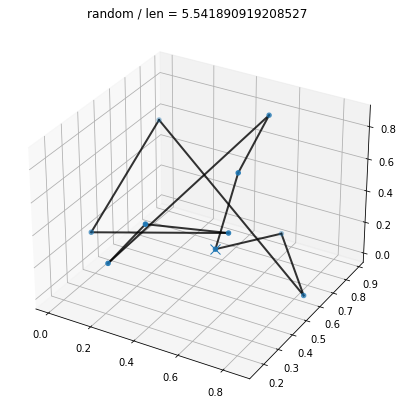

<Figure size 432x288 with 0 Axes>

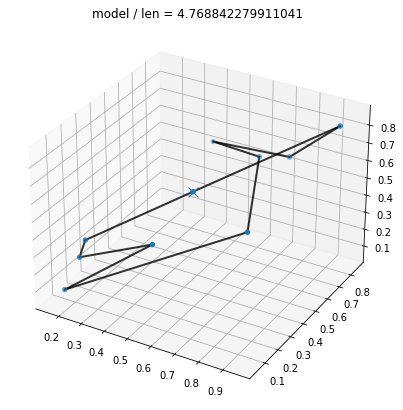

<Figure size 432x288 with 0 Axes>

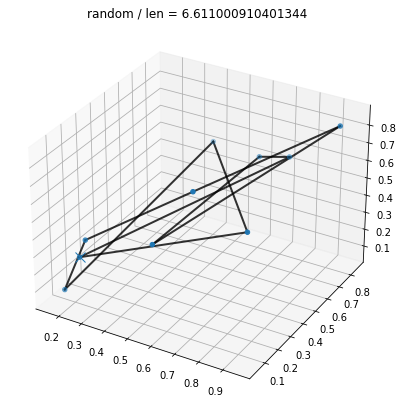

<Figure size 432x288 with 0 Axes>

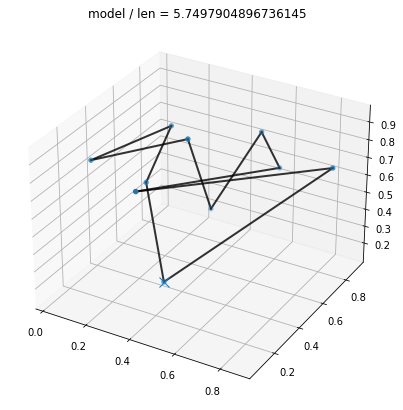

<Figure size 432x288 with 0 Axes>

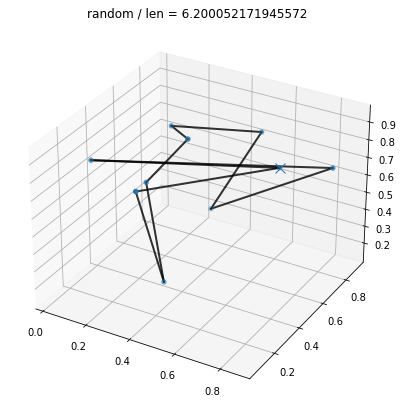

<Figure size 432x288 with 0 Axes>

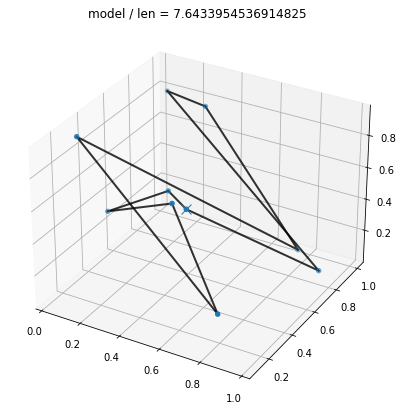

<Figure size 432x288 with 0 Axes>

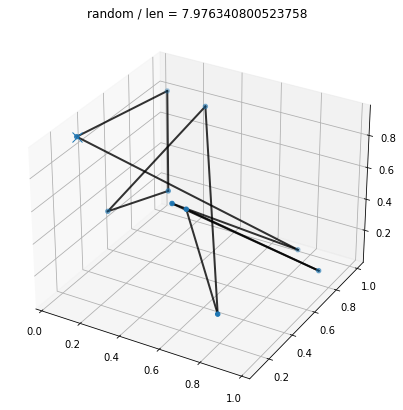

<Figure size 432x288 with 0 Axes>

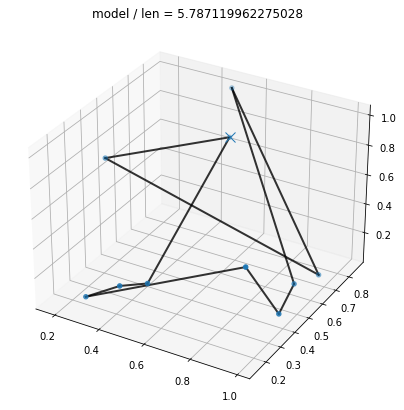

<Figure size 432x288 with 0 Axes>

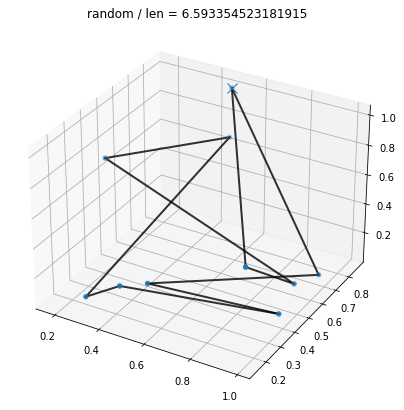

In [25]:
""" Get file with smallest distance
"""
all_lengths_fnames = [f for f in os.listdir(FOLDER_NAME) if f.endswith('.tar')]
shortest_fname = sorted(all_lengths_fnames, key=lambda s: float(s.split('.tar')[0].split('_')[-1]))[0]
print('shortest avg length found: {}'.format(shortest_fname.split('.tar')[0].split('_')[-1]))

""" Load checkpoint
"""
Q_func, Q_net, optimizer, lr_scheduler = init_model(os.path.join(FOLDER_NAME, shortest_fname))



    
""" Generate example solutions
"""
NR_NODES = 10
for sample in range(10):
    coords, W_np = get_graph_mat(n=NR_NODES)
    W = torch.tensor(W_np, dtype=torch.float32, requires_grad=False, device=device)
    
    solution = [random.randint(0, NR_NODES-1)]
    current_state = State(partial_solution=solution, W=W, coords=coords)
    current_state_tsr = state2tens(current_state)
    
    while not is_state_final(current_state):
        next_node, est_reward = Q_func.get_best_action(current_state_tsr, 
                                                       current_state)
        
        
        solution = solution + [next_node]
        current_state = State(partial_solution=solution, W=W, coords=coords)
        current_state_tsr = state2tens(current_state)
        
    plt.figure()
    plot_solution(coords, W, solution)
    plt.title('model / len = {}'.format(total_distance(solution, W)))
    
    # for comparison, plot a random solution
    plt.figure()
    random_solution = list(range(NR_NODES))
    plot_solution(coords, W, random_solution)
    plt.title('random / len = {}'.format(total_distance(random_solution, W)))